**Deliverable 2 : Dataset Selection & Annotation**

**Group 16:** Sarim Malik 26100129, Muhammad Nafees 26100029

In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.

---

**Dataset Preparation**

CIFAR-10 class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Number of classes: 10

Total samples: 35000
Total training samples (across partitions): 20000
Total test samples (global test set): 10000
Training samples per partition (avg): 4000.0


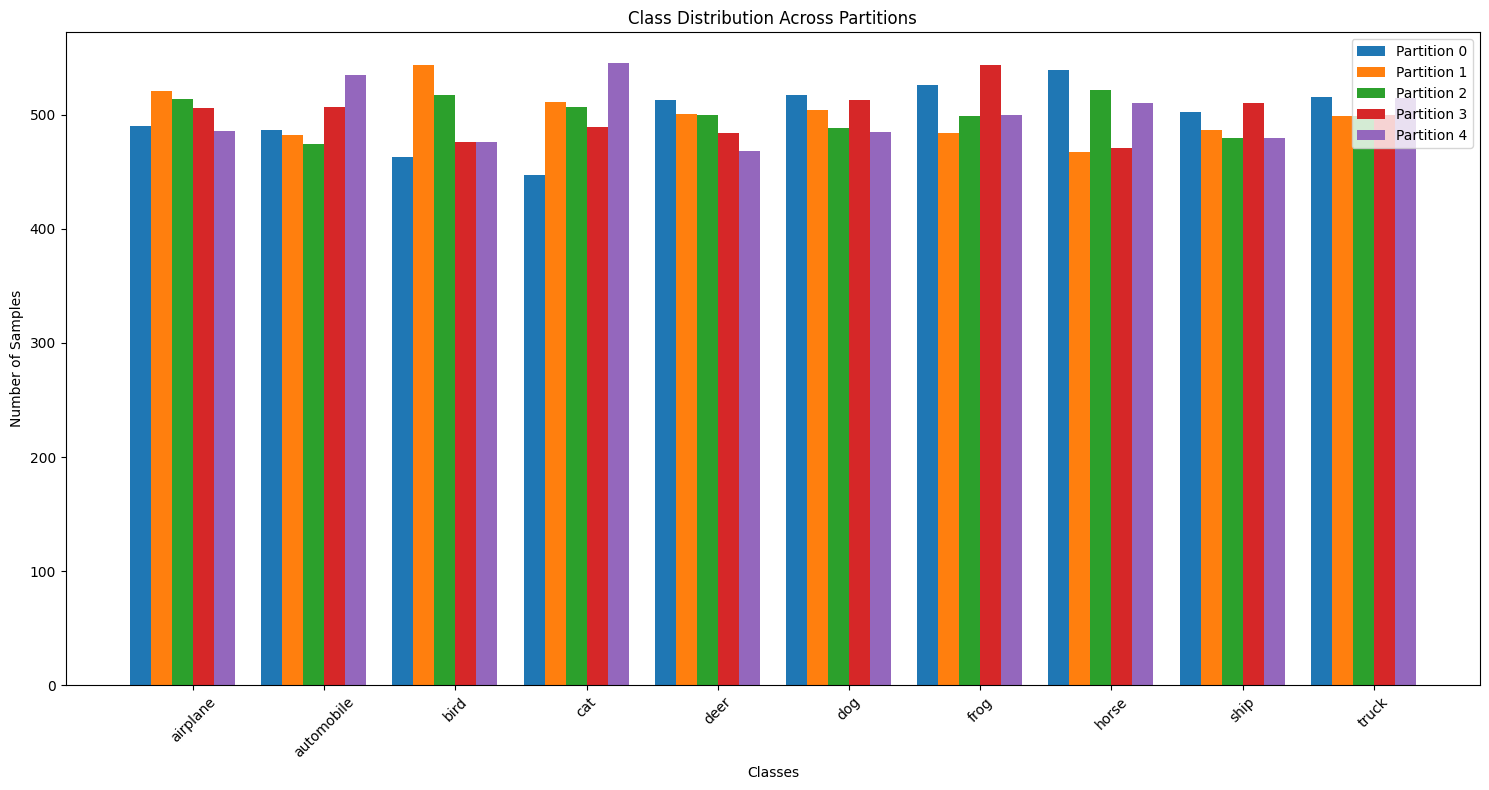

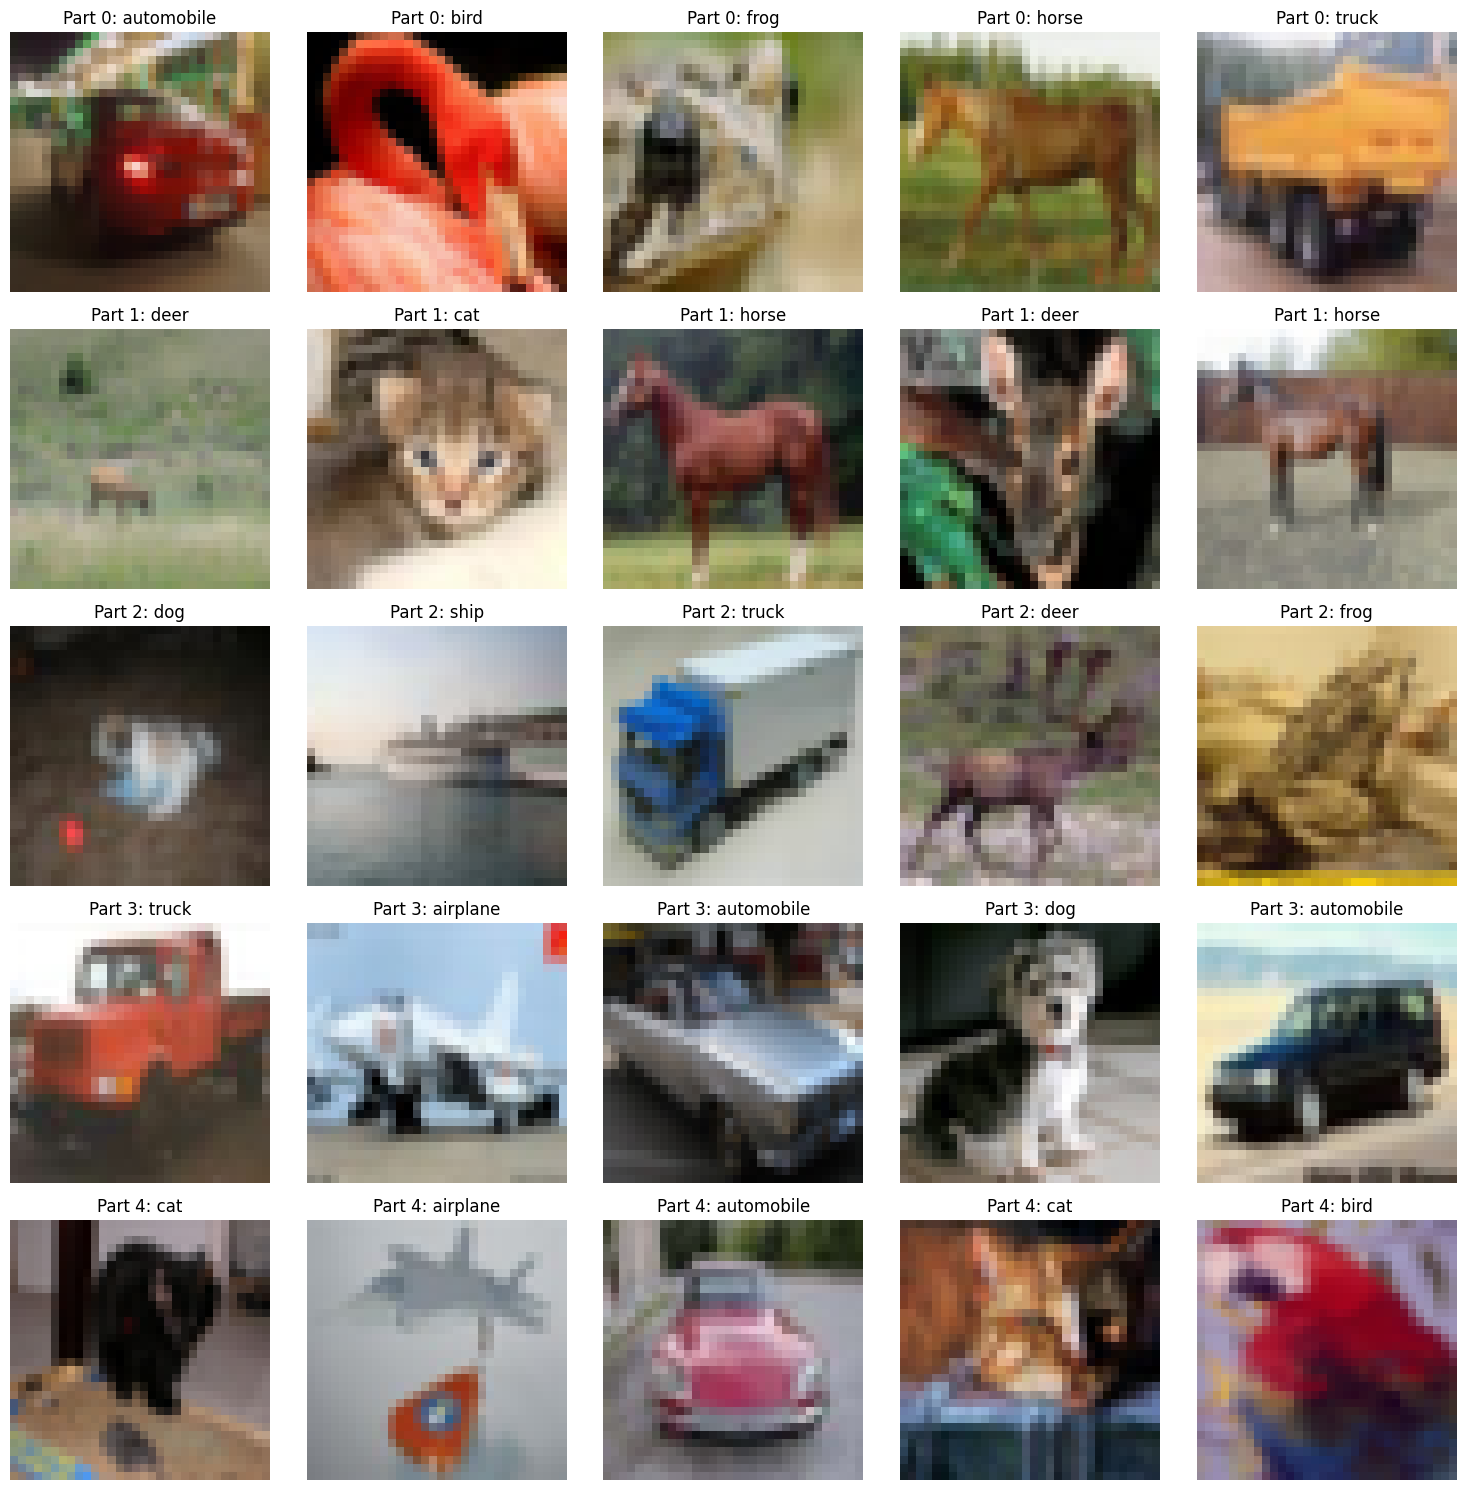

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
import os
import time
import datasets
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader
from collections import Counter
from flwr_datasets import FederatedDataset

def analyze_cifar10_partitions(num_partitions=10, samples_to_show=5):
    
    # Setup
    NUM_CLIENTS = 10
    BATCH_SIZE = 32

    # Disable verbose HuggingFace logging
    disable_progress_bar()

    cache_dir = os.path.join(os.getcwd(), "cached_datasets")
    os.makedirs(cache_dir, exist_ok=True)

    #  transformations for CIFAR-10
    pytorch_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    # Setup federated dataset
    try:
        download_config = datasets.DownloadConfig(
            cache_dir=cache_dir,
            resume_download=True,
            max_retries=3,
        )

        fds = FederatedDataset(
            dataset="cifar10",
            partitioners={"train": NUM_CLIENTS},
            download_config=download_config
        )

        testset = fds.load_split("test")
        class_names = testset.features["label"].names
        print(f"CIFAR-10 class names: {class_names}")
        print(f"Number of classes: {len(class_names)}")

        total_samples = 0
        train_samples = 0
        test_samples = len(testset)

        partition_stats = []
        all_partitions_data = []

        for i in range(min(num_partitions, NUM_CLIENTS)):
            partition = fds.load_partition(i)
            partition_size = len(partition)
            total_samples += partition_size

            #= train/test
            partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
            train_partition_size = len(partition_train_test["train"])
            test_partition_size = len(partition_train_test["test"])
            train_samples += train_partition_size

            label_counts = Counter(partition["label"])

            partition_stats.append({
                "id": i,
                "total_samples": partition_size,
                "train_samples": train_partition_size,
                "test_samples": test_partition_size,
                "class_distribution": {class_names[k]: v for k, v in label_counts.items()}
            })

            partition_with_transform = partition.with_transform(apply_transforms)
            loader = DataLoader(partition_with_transform, batch_size=samples_to_show)
            batch = next(iter(loader))
            images, labels = batch["img"], batch["label"]

            images_np = images.permute(0, 2, 3, 1).numpy()
            images_np = images_np / 2 + 0.5

            all_partitions_data.append({
                "id": i,
                "images": images_np[:samples_to_show],
                "labels": [class_names[label] for label in labels[:samples_to_show]]
            })

        print(f"\nTotal samples: {total_samples + test_samples}")
        print(f"Total training samples (across partitions): {train_samples}")
        print(f"Total test samples (global test set): {test_samples}")
        print(f"Training samples per partition (avg): {train_samples / num_partitions:.1f}")

        plt.figure(figsize=(15, 8))

        x = np.arange(len(class_names))
        width = 0.8 / num_partitions

        for i, stats in enumerate(partition_stats):
            distribution = [stats["class_distribution"].get(class_name, 0) for class_name in class_names]
            plt.bar(x + i*width - 0.4, distribution, width, label=f'Partition {i}')

        plt.xlabel('Classes')
        plt.ylabel('Number of Samples')
        plt.title('Class Distribution Across Partitions')
        plt.xticks(x, class_names, rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

        fig, axs = plt.subplots(num_partitions, samples_to_show, figsize=(15, 3*num_partitions))

        for i, partition_data in enumerate(all_partitions_data):
            for j in range(samples_to_show):
                ax = axs[i, j] if num_partitions > 1 else axs[j]
                ax.imshow(partition_data["images"][j])
                ax.set_title(f"Part {i}: {partition_data['labels'][j]}")
                ax.axis('off')

        plt.tight_layout()
        plt.show()

        means = []
        stds = []

        for i in range(min(num_partitions, NUM_CLIENTS)):
            partition = fds.load_partition(i).with_transform(apply_transforms)
            loader = DataLoader(partition, batch_size=100)

            partition_means = []
            partition_stds = []

            for batch in loader:
                images = batch["img"]
                batch_mean = images.mean(dim=[0, 2, 3]).numpy()
                batch_std = images.std(dim=[0, 2, 3]).numpy()
                partition_means.append(batch_mean)
                partition_stds.append(batch_std)

            partition_mean = np.mean(partition_means, axis=0)
            partition_std = np.mean(partition_stds, axis=0)

            means.append(partition_mean)
            stds.append(partition_std)


        return partition_stats, class_names

    except Exception as e:
        print(f"Error in dataset analysis: {str(e)}")
        return None, None

cifar10_stats, cifar10_classes = analyze_cifar10_partitions(num_partitions=5)

# CIFAR-10
# Dataset Strategy for **Project: KD in Federated Learning**

## **Project Pipeline Overview**

Our project implements a bidirectional knowledge distillation framework for federated learning.The pipeline begins by pre-training a larger teacher model on a subset of data. During federation, distributed clients each train smaller student models on their local data, guided by the teacher's knowledge. After each round, the server aggregates student models via FedAvg (aggregation strategy subject to change) and employs a meta-distillation strategy where the teacher evolves based on collective insights from students across the federation.

This creates a continuous knowledge cycle where the teacher guides student learning while simultaneously adapting to the distributed expertise captured across heterogeneous data partitions. The system is meant to significantly reduce network bandwidth requirements through model compression while maintaining competitive accuracy on different data distributions (IID, non-IID).

Our architecture integrates NAS techniqeus such as Bayesian Optimisation, Genetic Algorithms that automatically optimizes client-side student architectures based on device capabilities and local data characteristics (this is meant to simulate resource constraints on edge devices). Additionally, we aim to implement surrogate models at the client side that predict model updates, further reducing communication overhead while maintaining performance in resource-constrained environments.


---

## **Why CIFAR-10?**

CIFAR-10 is a great fit for our KD-based federated learning setup. It offers a balanced set of 60,000 images across 10 classes, with 50,000 training images and 10,000 test images. We partition the 50,000 training images across 10 clients (showing only 5 partitions here though), with each client receiving approximately 5,000 images. These are then split 80/20 for local training and validation, giving each client roughly 4,000 training examples and 1,000 validation examples.

---

## **Partitioning Across Clients**

We aim to split CIFAR-10 among 10 clients (subject to change) to mimic real-world, uneven data distributions:

- **Non-IID setup**: Each client would get a unique mix of classes, reflecting real-world data heterogeneity (might test via IID as well).
- **80/20 split**: Local data will be divided into 80% training and 20% validation.
- **Global test set**: A separate test set evaluates overall performance.

Each client ends up with ~5,000 training examples, with varied class distributions.


**Dataset Summary:**

Note: defined NUM_CLIENTS = 10 but requested to analyze only num_partitions=5 for purposes of analysis in this notebook


CIFAR-10 full dataset: 60,000 images

50,000 training images
10,000 test images
Your partition setup:

Training data divided into 10 partitions (about 5,000 per partition)
We are analyzimg only 5 of those 10 partitions in this notebook
So: 5 partitions × ~5,000 = ~25,000 training images
After the local 80/20 split: 20,000 training + 5,000 validation
The global test set remains 10,000 images
Total: 25,000 + 10,000 = 35,000 images

---

## **Why CIFAR-10 Makes This Work Well**

Several of CIFAR-10's features align well with our KD-FL goals:

- **Visual feature depth**: Students benefit from compressing the richer hierarchies learned by the teacher.
- **Class similarity**: Overlapping classes (like cats/dogs) improve soft label learning.
- **Fixed image size**: Simplifies model design and distillation.
- **Rich multi-modal features**: Color, shape, and texture offer plenty of learning signals.



---

Have also included the dataloader for MNIST in case we need to back our results via the benchmarking framework that we will be developing later

**Part 2: MNIST Dataset Analysis**

MNIST classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Number of classes: 10

Total samples: 40000
Total training samples (across partitions): 24000
Total test samples (global test set): 10000
Training samples per partition (avg): 4800.0


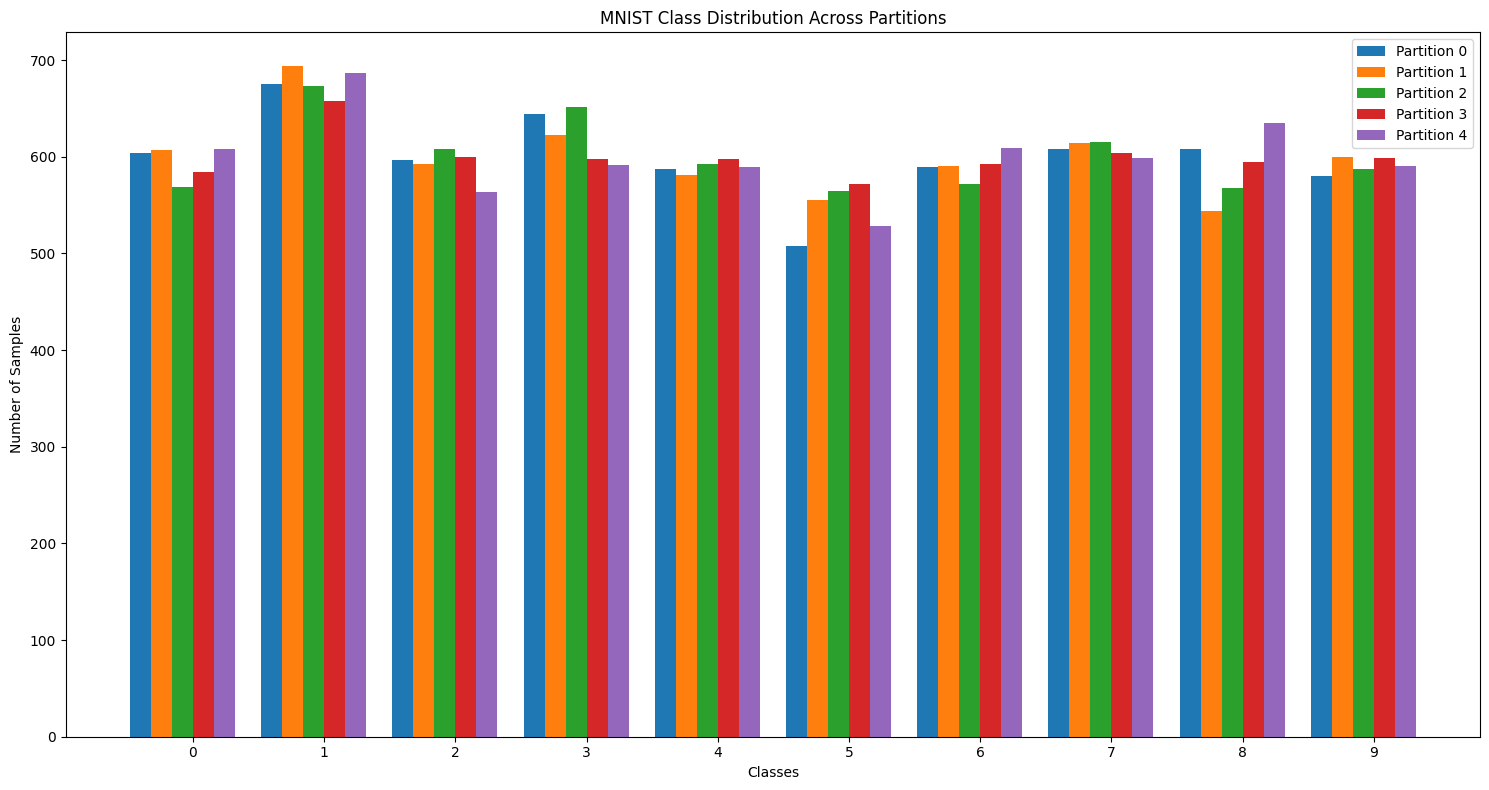

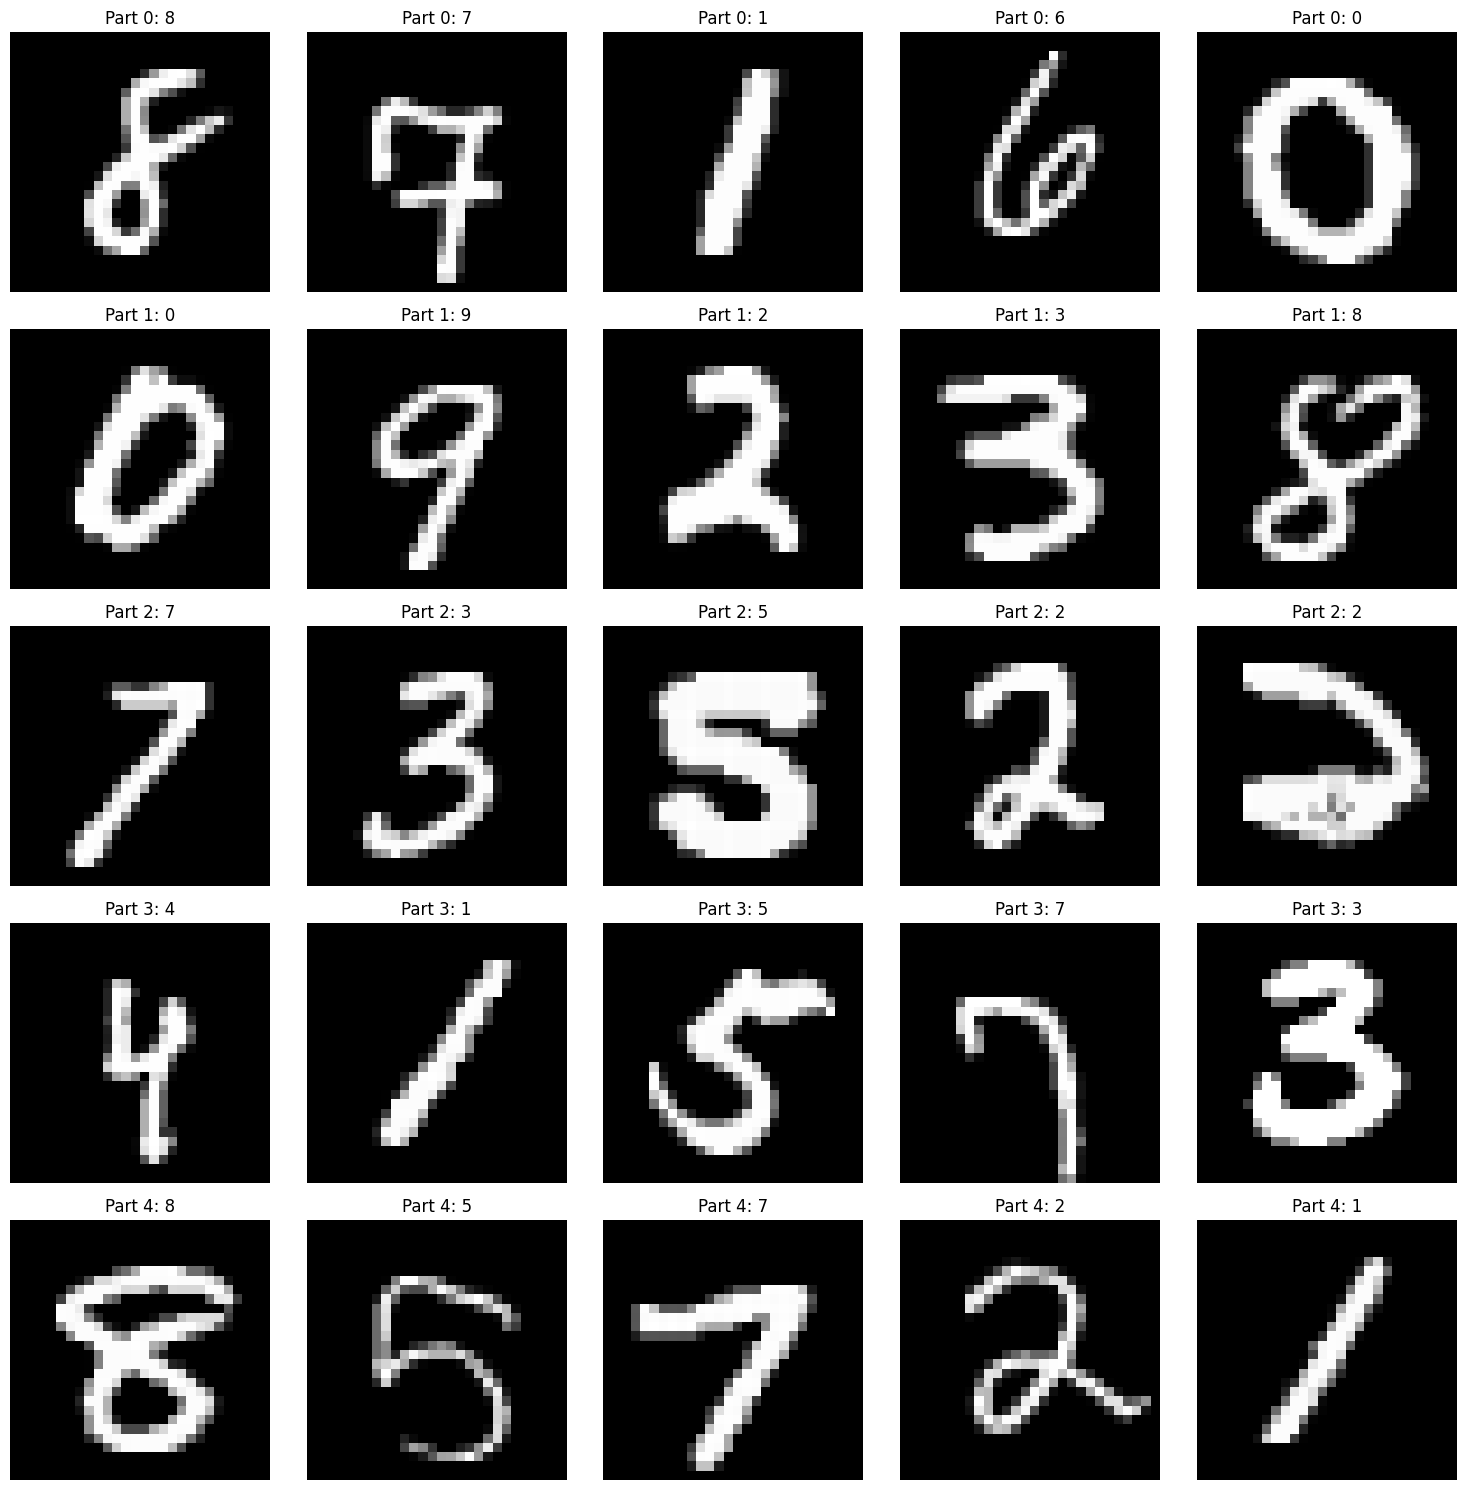

In [8]:
def analyze_mnist_partitions(num_partitions=10, samples_to_show=5):

    # Setup
    NUM_CLIENTS = 10
    BATCH_SIZE = 32

    disable_progress_bar()

    cache_dir = os.path.join(os.getcwd(), "cached_datasets")
    os.makedirs(cache_dir, exist_ok=True)

    pytorch_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  #  standard normalization
    ])

    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    # Setup federated dataset
    try:
        download_config = datasets.DownloadConfig(
            cache_dir=cache_dir,
            resume_download=True,
            max_retries=3,
        )

        fds = FederatedDataset(
            dataset="mnist",
            partitioners={"train": NUM_CLIENTS},
            download_config=download_config
        )

        class_names = [str(i) for i in range(10)]
        print(f"MNIST classes: {class_names}")
        print(f"Number of classes: {len(class_names)}")

        total_samples = 0
        train_samples = 0
        test_samples = len(fds.load_split("test"))

        partition_stats = []
        all_partitions_data = []

        for i in range(min(num_partitions, NUM_CLIENTS)):
            partition = fds.load_partition(i)
            partition_size = len(partition)
            total_samples += partition_size

            partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
            train_partition_size = len(partition_train_test["train"])
            test_partition_size = len(partition_train_test["test"])
            train_samples += train_partition_size

            label_counts = Counter(partition["label"])

            partition_stats.append({
                "id": i,
                "total_samples": partition_size,
                "train_samples": train_partition_size,
                "test_samples": test_partition_size,
                "class_distribution": {class_names[k]: v for k, v in label_counts.items()}
            })

            partition_with_transform = partition.with_transform(apply_transforms)
            loader = DataLoader(partition_with_transform, batch_size=samples_to_show)
            batch = next(iter(loader))

            images, labels = batch["image"], batch["label"]

            images_np = images.squeeze(1).numpy()

            all_partitions_data.append({
                "id": i,
                "images": images_np[:samples_to_show],
                "labels": [class_names[label] for label in labels[:samples_to_show]]
            })

        print(f"\nTotal samples: {total_samples + test_samples}")
        print(f"Total training samples (across partitions): {train_samples}")
        print(f"Total test samples (global test set): {test_samples}")
        print(f"Training samples per partition (avg): {train_samples / num_partitions:.1f}")

        plt.figure(figsize=(15, 8))

        x = np.arange(len(class_names))
        width = 0.8 / num_partitions

        for i, stats in enumerate(partition_stats):
            distribution = [stats["class_distribution"].get(class_name, 0) for class_name in class_names]
            plt.bar(x + i*width - 0.4, distribution, width, label=f'Partition {i}')

        plt.xlabel('Classes')
        plt.ylabel('Number of Samples')
        plt.title('MNIST Class Distribution Across Partitions')
        plt.xticks(x, class_names)
        plt.legend()
        plt.tight_layout()
        plt.show()

        fig, axs = plt.subplots(num_partitions, samples_to_show, figsize=(15, 3*num_partitions))

        for i, partition_data in enumerate(all_partitions_data):
            for j in range(samples_to_show):
                ax = axs[i, j] if num_partitions > 1 else axs[j]
                ax.imshow(partition_data["images"][j], cmap='gray')
                ax.set_title(f"Part {i}: {partition_data['labels'][j]}")
                ax.axis('off')

        plt.tight_layout()
        plt.show()

        means = []
        stds = []

        for i in range(min(num_partitions, NUM_CLIENTS)):
            partition = fds.load_partition(i).with_transform(apply_transforms)
            loader = DataLoader(partition, batch_size=100)

            partition_means = []
            partition_stds = []

            for batch in loader:
                images = batch["image"]
                batch_mean = images.mean().item()
                batch_std = images.std().item()
                partition_means.append(batch_mean)
                partition_stds.append(batch_std)

            # Average over all batches
            partition_mean = np.mean(partition_means)
            partition_std = np.mean(partition_stds)

            means.append(partition_mean)
            stds.append(partition_std)



        return partition_stats, class_names

    except Exception as e:
        print(f"Error in MNIST dataset analysis: {str(e)}")
        return None, None

mnist_stats, mnist_classes = analyze_mnist_partitions(num_partitions=5)

---